In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    readHEPDataCsv,
    implementPairDecayLimit,
    implementPairProductionLimit,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# ATLAS 13TeV LHC

## `H > hSM hSM > gamgam bb` [1807.04873](https://arxiv.org/abs/1807.04873)

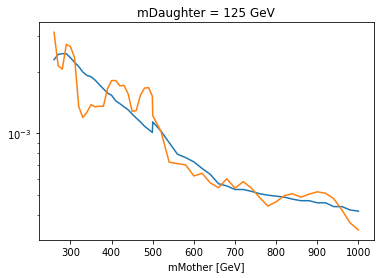

Looks good. Saving this to H_LHC13_ATLAS_36.json


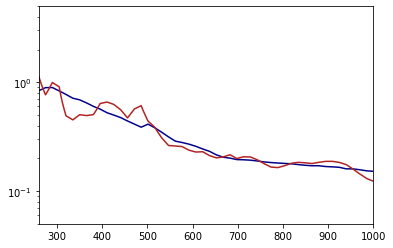

In [2]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1682345/Table%2012/1/csv"
)
df = dfs[0].rename(
    columns={
        "$m_X$ [GeV]": "mMother",
        "Cross section upper limit at 95% CL [pb]": "obs",
    }
)
assert np.allclose(df.mMother, dfs[1]["$m_X$ [GeV]"])
df["exp"] = dfs[1]["Cross section upper limit at 95% CL [pb]"]
# two limits for 500GeV because selection changes, change the first one to 499GeV
df.loc[df.mMother == 500, "mMother"] = [499, 500]
df["mDaughter1"] = 125
refBr = 2 * HP.SMHiggs(125).br("gamgam") * HP.SMHiggs(125).br("bb")
df.obs *= refBr
df.exp *= refBr
limitFile = implementPairDecayLimit(
    1682345,
    {
        "production": ["H"],
        "firstDecay": ["gamgam"],
        "secondDecay": ["bb"],
    },
    "https://doi.org/10.17182/hepdata.82818.v1/t12",
    df,
    massResolution={
        "firstDaughter": {"absolute": 0, "relative": 0.015},  # p. 8
        "secondDaughter": {
            "absolute": 0,
            "relative": 0.015,
        },  # they explicitely assume that mjj=mgamgam
        "mother": {"absolute": 0, "relative": 0.03},  # p. 8
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("bb", 1)
h2.setDecayWidth("gamgam", 1)
h2.setMass(125)
h1.setMass(125)
hm = np.linspace(260, 1000)
r = np.linspace(0.05,5)

def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate* refBr)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


## non-res `pp > hSM hSM > gamgam bb` [1807.04873](https://arxiv.org/abs/1807.04873)

In [2]:
df = pd.DataFrame({"m": [125], "obs": 0.73, "exp": 0.93})
sm = HP.SMHiggs(125)
df.obs *= sm.br("gamgam") * sm.br("bb")
df.exp *= sm.br("gamgam") * sm.br("bb")
limitFile = implementPairProductionLimit(
    1682345,
    {"firstDecay": ["gamgam"], "secondDecay": ["bb"]},
    "Tab. 4",
    df,
    idSuffix=1,
    massResolution={
        "firstParticle": {"absolute": 0, "relative": 1.5e-2},  # p. 8
        "secondParticle": {"absolute": 40, "relative": 0},  # bb resolution is bad
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setDecayWidth("gamgam", 1.0)
h1.setMass(125)
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h2.setDecayWidth("bb", 1.0)
h2.setMass(125)
pred.setBsmPairCxn("LHC13", "h1", "h2", 1.0)
res = lim.apply(pred)
print(res)
assert np.isclose(res[0].obsRatio(), 1.0 / df.obs[0])
assert np.isclose(res[0].expRatio(), 1.0 / df.exp[0])


Looks good. Saving this to nonres_LHC13_ATLAS_36.json
[<Higgs.bounds.AppliedLimit limitId: 1807048731, obsRatio: 1001.877, expRatio: 786.419, for: ["h1", "+", "h2"]>]


# ATLAS 8TeV LHC

## `H > hSM hSM > gamgambb` [1406.5053](https://arxiv.org/abs/1406.5053)

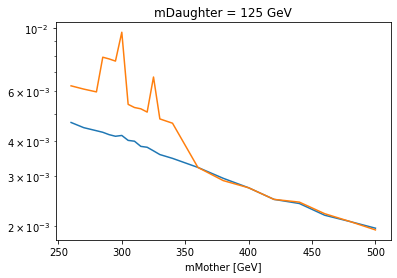

Looks good. Saving this to H_LHC8_ATLAS_20.json


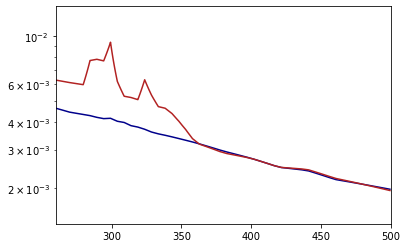

In [3]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1301558/Table%202/1/csv", skip=1
)
df = dfs[0].rename(
    columns={"MX [GEV]": "mMother", "SIG(fiducial) * BR(X --> HIGGS HIGGS) [PB]": "obs"}
)
assert np.allclose(df.mMother, dfs[1]["MX [GEV]"])
df["exp"] = dfs[1]["SIG(fiducial) * BR(X --> HIGGS HIGGS) [PB]"]
df["mDaughter1"] = 125
refBr = 2 * HP.SMHiggs(125).br("bb") * HP.SMHiggs(125).br("gamgam")
df.obs *= refBr
df.exp *= refBr
limitFile = implementPairDecayLimit(
    "1406.5053",
    {
        "production": ["H"],
        "firstDecay": ["gamgam"],
        "secondDecay": ["bb"],
    },
    "https://doi.org/10.17182/hepdata.64171",
    df,
    massResolution={
        "firstDaughter": resolution.gamgam["125"],  # gamgam
        "secondDaughter": resolution.bb["medMass"],  # bb
        "mother": {
            "absolute": -30,
            "relative": 0.17,
        },  # linear fit to the numbers given on p. 3
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("bb", 1.0)
h2.setDecayWidth("gamgam", 1.0)
h1.setMass(125)
h2.setMass(125)
hm = np.linspace(260, 500)
r = np.linspace(0.5, 5) * refBr


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
ax.set_yscale("log")
plt.show()
